In [92]:
# needed for random number generator
import random
# get statistics
from statistics import stdev

# global variables
deck = [4, 4, 4, 4, 4, 4, 4, 4, 4, 16]  # card deck, list index is face value, list value is card count (1 per suite)
finite = False  # if true, then finite deck, else it is an infinite deck


# DEALER AND HELPER FUNCTIONS #
def shuffle():
    """
    Maximizes/restores the deck between games in finite mode.
    """

    global deck
    deck = [4, 4, 4, 4, 4, 4, 4, 4, 4, 16]


def is_empty():
    """
    Checks if there are still cards to draw in finite mode.
    """

    # by default, it is considered empty
    for x in deck:
        if x > 0:
            return False  # returns False if it is not empty
    return True


def draw_card():
    """
    Draws a card, and if we're in finite mode it also removes the card from the deck.
    """

    global finite

    # randomly generate a number between 1-13 (includes ace, jack, queen, and king)
    num = random.randint(1, 13)
    # if over 10 (jack, queen, king), the face value is still 10
    num = 10 if num > 10 else num

    # for finite decks
    if finite:
        if deck[num - 1] > 0:
            deck[num - 1] = deck[num - 1] - 1
            return num if num is not 1 else 11
        elif not is_empty():
            return draw_card()
    else:
        return num if num is not 1 else 11


def deal():
    """
    Shuffles then draws two cards from the deck, returns in a list.
    """

    shuffle()
    return [draw_card(), draw_card()]


def check_softness(hand):
    """
    Sees if we have any ace in our hand that can be treated as a 1 or 11 without going over.
    Checks if the given hand is soft (ace is set to 11) or is hard (ace is set to 1).
    """

    # index flag
    index = -1

    # for each card in hand, if one has a value of 11, set index to that card
    for i in range(len(hand) - 1, 0 - 1, -1):
        if hand[i] == 11:
            index = i

    # if index changed then it's indeed soft, but if still -1 then it's hard/false
    is_soft = True if index is not -1 else False

    # return the softness value and the soft card's index in the list
    return is_soft, index


def harden(hand, index):
    """
    Hardens the hand, turning the ace from an 11 to a 1.
    Uses index to see which card from the hand is the ace we want to change.
    """

    hand[index] = 1
    return hand


def harden_until(new_card, hand):
    """
    Takes in a value we want to add to the hand, and hardens the hand until the new card can be accepted, or you bust.
    These functions can be reused for any policy that cares about soft/hard hands.
    """

    # when adding a new card, if the new hand value is over 21
    if new_card + sum(hand) > 21:

        # check to see if it's still soft
        is_soft, index = check_softness(hand)

        # if it is, harden it
        if is_soft:
            return harden_until(new_card, harden(hand, index))

        # if it isn't soft but the new card is 11, harden it
        elif new_card == 11:
            return harden_until(1, hand)

        # if it isn't soft then it's already hard, we can't do anything, we've lost dude
        else:
            hand.clear()
            return hand, False

    # otherwise, we add a new card and return the (successful) new hand
    else:
        hand.append(new_card)
        return hand, True


# POLICY FUNCTIONS #
def policy_1():
    """
    POLICY 1:
        If our hand ≥ 17, stick.
        Else, hit.
    """

    # first receive a hand
    hand = deal()

    # follow policy
    return policy_1_r(hand), draw_card()


def policy_1_r(hand):
    """
    Recursive function for Policy 1.
    """

    # if our hand is greater than 21, we've bust (lost), unless the hand is soft
    if sum(hand) > 21:

        # check softness of our hand
        is_soft, index = check_softness(hand)
        # if soft, harden
        if is_soft:
            harden(hand, index)

        # if hard, we've bust (lost)
        else:
            hand.clear()
            return hand

    # if our hand is less than 17, we hit
    # otherwise, we do nothing, effectively sticking
    if sum(hand) < 17:
        new_card = draw_card()

        # as long as the deck isn't empty
        if new_card is not None:
            # try to add the card to our hand
            hand, success = harden_until(new_card, hand)
            # if we couldn't add the card while trying to harden until it worked, we've bust (lost)
            if success is not True:
                hand.clear()
                return hand
            # otherwise follow policy again
            else:
                hand = policy_1_r(hand)

    # return current hand
    return hand


def policy_2():
    """
    POLICY 2:
        If our hand ≥ 17, and hard, stick.
        Else, hit (unless our hand = 21).
    """

    # first receive a hand
    hand = deal()

    # follow policy
    return policy_2_r(hand), draw_card()


def policy_2_r(hand):
    """
    Recursive function for Policy 2.
    """

    # if our hand is 21 (Blackjack) we win/draw, return hand
    if sum(hand) == 21:
        return hand

    # if 17 or above
    if sum(hand) >= 17:

        # check softness of our hand
        is_soft, index = check_softness(hand)
        # if hard, return current hand (stick)
        if is_soft is not True:
            return hand

    # hit, if deck isn't empty
    new_card = draw_card()
    if new_card is not None:

        # receive hardened hand
        hand, success = harden_until(new_card, hand)

        # if hardened hand is over 21, success is False, we've bust (lost)
        if success is not True:
            hand.clear()
            return hand

        # else return current hand
        else:
            return policy_2_r(hand)


def policy_3():
    """
    POLICY 3:
        If our hand ≥ 17, and hard, stick.
        If our hand ≥ 17, and soft, stick 50% of the time.
        Else, hit (unless our hand = 21).
    """

    # first receive a hand
    hand = deal()

    # follow policy
    return policy_3_r(hand), draw_card()


def policy_3_r(hand):
    """
    Recursive function for Policy 3.
    """

    # if our hand is 21 (Blackjack) we win/draw, return hand
    if sum(hand) == 21:
        return hand

    # if 17 or above
    if sum(hand) >= 17:

        # check softness of our hand
        is_soft, index = check_softness(hand)
        # if hard, return current hand (stick)
        if is_soft is not True:
            return hand

        # ! HERE'S THE DIFFERENCE FROM POLICY 2 !
        # if we have a soft hand while above 17, we essentially flip a coin (50% chance)
        # if true then stick, otherwise we hit
        elif is_soft is True:
            if random.choice([True, False]) is True:
                return hand

    # hit, if deck isn't empty
    new_card = draw_card()
    if new_card is not None:

        # receive hardened hand
        hand, success = harden_until(new_card, hand)

        # if hardened hand is over 21, success is False, we've bust (lost)
        if success is not True:
            hand.clear()
            return hand

        # else return current hand
        else:
            return policy_3_r(hand)


def policy_4():
    """
    POLICY 4:
        Always stick.
    """

    # first receive a hand
    hand = deal()

    # if our hand is already over 21, that means we have two aces, so treat the first ace as a 1
    if sum(hand) > 21:
        hand[0] = 1

    # return current hand
    return hand, draw_card()


def policy_5():  # based on policy 2
    """
    POLICY 5:
        If Dealer's exposed card is ace or above 7, follow Policy 2.
        Else, if Player's card is 12 or above and hard, stick.
        Else, hit.
    """

    # first receive a hand
    hand = deal()

    # check dealer's exposed card, the player decides the policy based on that
    # if dealer got an ace or a card larger than 7, follow policy 2
    dealers_card = draw_card()
    if (dealers_card == 1) or (dealers_card > 7):
        return policy_2_r(hand), dealers_card
    # otherwise continue policy 5
    else:
        return policy_5_r(hand), dealers_card


def policy_5_r(hand):
    """
    Recursive function for Policy 5.
    """

    # if our hand is 21 (Blackjack) we win/draw, return hand
    if sum(hand) == 21:
        return hand

    # if 12 or above
    if sum(hand) >= 12:

        # check softness of our hand
        is_soft, index = check_softness(hand)
        # if hard, return current hand (stick)
        if is_soft is not True:
            return hand

    # hit, if deck isn't empty
    new_card = draw_card()
    if new_card is not None:

        # receive hardened hand
        hand, success = harden_until(new_card, hand)

        # if hardened hand is over 21, success is False, we've bust (lost)
        if success is not True:
            hand.clear()
            return hand

        # else return current hand
        else:
            return policy_5_r(hand)


def policy_6():  # based on policy 3
    """
    POLICY 6:
        If Dealer's exposed card is ace or above 7, follow Policy 3.
        Else, if Player's card 12 or above and hard, stick.
        Else, if Player's card 12 or above and soft, stick 50% chance of the time.
        Else, hit.
    """

    # first receive a hand
    hand = deal()

    # check dealer's exposed card, the player decides the policy based on that
    # if dealer got an ace or a card larger than 7, follow policy 3
    dealers_card = draw_card()
    if (dealers_card == 1) or (dealers_card > 7):
        return policy_3_r(hand), dealers_card
    # otherwise continue policy 6
    else:
        return policy_6_r(hand), dealers_card


def policy_6_r(hand):
	"""
	Recursive function for Policy 6.
	"""

	# if our hand is 21 (Blackjack) we win/draw, return hand
	if sum(hand) == 21:
		return hand

	# if 12 or above
	if sum(hand) >= 12:

		# check softness of our hand
		is_soft,index=check_softness(hand)
		# if hard, return current hand (stick)
		if is_soft is not True:
			return hand
		# ! HERE'S THE DIFFERENCE FROM POLICY 5 !
		# if we have a soft hand while above 12, we essentially flip a coin (50% chance)
		# if true then stick, otherwise we hit
		elif is_soft is True:
			if random.choice([True, False]) is True:
				return hand

	# hit, if deck isn't empty
	new_card=draw_card()
	if new_card is not None:

		# receive hardened hand
		hand,success=harden_until(new_card,hand)

		# if hardened hand is over 21, success is False, we've bust (lost)
		if success is not True:
			hand.clear()
			return hand

		# return current hand
		else:
			return policy_6_r(hand)

#Policy 7 Helper function
def check_likelihood(hand,acceptable_range):
    safe=False
    target=21-sum(hand)
    if target > 10:
        return True
    acceptable=0
    for i in range(target):
        acceptable+=deck[i]

    unacceptable=0
    for i in range(len(deck)-target):
        unacceptable+=deck[i+target]

    return ((acceptable/(acceptable+unacceptable))>=acceptable_range)

#Policy 7 25%
def policy_7_25():
    hand=deal()
    dealers_card=draw_card()
    return policy_7_r_25(hand),dealers_card

def policy_7_r_25(hand):
    acceptable_range = 0.25
    if sum(hand) > 21:
        is_soft,index=check_softness(hand)
        if is_soft:
            harden(hand,index)
        else:
            hand.clear()
            return hand

    if check_likelihood(hand,acceptable_range):
        new_card=draw_card()
        if new_card is not None:
            hand,success=harden_until(new_card,hand)
            if success is not True:
                hand.clear()
                return hand
            else:
                hand=policy_7_r_25(hand)
    return hand

#Policy 7 75%
def policy_7_75():
    hand=deal()
    dealers_card=draw_card()
    return policy_7_r_75(hand),dealers_card

def policy_7_r_75(hand):
    acceptable_range = 0.75
    if sum(hand) > 21:
        is_soft,index=check_softness(hand)
        if is_soft:
            harden(hand,index)
        else:
            hand.clear()
            return hand

    if check_likelihood(hand,acceptable_range):
        new_card=draw_card()
        if new_card is not None:
            hand,success=harden_until(new_card,hand)
            if success is not True:
                hand.clear()
                return hand
            else:
                hand=policy_7_r_75(hand)
    return hand


# STATISTICAL FUNCTIONS #
def get_stats(policy, num_of_tests):
    policy_stats = {'P_Wins': 0, 'D_Wins': 0, 'P_Bust': 0, 'D_Bust': 0, 'Draw': 0, 'Win_vs_Loss_Rate': 0,
                    'Win_and_Draw_vs_Loss_Rate': 0, 'num_of_tests': num_of_tests}
    for i in range(num_of_tests):
        hand, dealers_card = policy()

        dealers_hand = [dealers_card, draw_card()]
        dealers_hand = policy_1_r([dealers_card, draw_card()])

        if sum(hand) == sum(dealers_hand):
            if sum(hand) == 0:
                pass
            # policy_stats['P_Bust'] += 1
            # policy_stats['D_Bust'] += 1
            else:
                policy_stats['Draw'] += 1
        elif sum(hand) == 0:
            policy_stats['D_Wins'] += 1
            policy_stats['P_Bust'] += 1
        elif sum(hand) == 21:
            policy_stats['P_Wins'] += 1
        elif sum(dealers_hand) == 0:
            policy_stats['P_Wins'] += 1
            policy_stats['D_Bust'] += 1
        elif sum(hand) > sum(dealers_hand):
            policy_stats['P_Wins'] += 1
        else:
            policy_stats['D_Wins'] += 1

    policy_stats['Win_vs_Loss_Rate'] = policy_stats['P_Wins'] / policy_stats['D_Wins']
    policy_stats['Win_and_Draw_vs_Loss_Rate'] = (policy_stats['P_Wins'] + policy_stats['Draw']) / policy_stats['D_Wins']
    return policy_stats


# Get all statistics
def get_all_stats(policy, number_of_tests, average_over_x_tests):
    total_stats = {'P_Wins_total': [], 'D_Wins_total': [], 'P_Bust_total': [], 'D_Bust_total': [], 'Draw_total': []}
    for i in range(average_over_x_tests):
        current_stats = get_stats(policy, number_of_tests)
        total_stats['P_Wins_total'].append(current_stats['P_Wins'])
        total_stats['D_Wins_total'].append(current_stats['D_Wins'])
        total_stats['P_Bust_total'].append(current_stats['P_Bust'])
        total_stats['D_Bust_total'].append(current_stats['D_Bust'])
        total_stats['Draw_total'].append(current_stats['Draw'])
    p_ave = sum(total_stats['P_Wins_total']) / average_over_x_tests
    d_ave = sum(total_stats['D_Wins_total']) / average_over_x_tests
    p_b_ave = sum(total_stats['P_Bust_total']) / average_over_x_tests
    d_b_ave = sum(total_stats['D_Bust_total']) / average_over_x_tests
    draw_ave = sum(total_stats['Draw_total']) / average_over_x_tests
    n = number_of_tests
    # returns tuple with (average, standard deviation, % as total)
    p_tuple = (p_ave, float("{0:.2f}".format(stdev(total_stats['P_Wins_total']))), float("{0:.2f}".format(p_ave / n * 100)))
    d_tuple = (d_ave, float("{0:.2f}".format(stdev(total_stats['D_Wins_total']))), float("{0:.2f}".format(d_ave / n * 100)))
    p_b_tuple = (p_b_ave, float("{0:.2f}".format(stdev(total_stats['P_Bust_total']))), float("{0:.2f}".format(p_b_ave / n * 100)))
    d_b_tuple = (d_b_ave, float("{0:.2f}".format(stdev(total_stats['D_Bust_total']))), float("{0:.2f}".format(d_b_ave / n * 100)))
    draw_tuple = (draw_ave, float("{0:.2f}".format(stdev(total_stats['Draw_total']))), float("{0:.2f}".format(draw_ave / n * 100)))
    return {'P_Wins': p_tuple, 'D_Wins': d_tuple, 'P_Bust': p_b_tuple, 'D_Bust': d_b_tuple, 'Draw': draw_tuple,
            'totals': total_stats}


# STATISTICAL FUNCTIONS MODIFIED #
def get_stats_mod(policy, num_of_tests):
    stats_array = []
    p_wins = 1
    d_wins = -1
    draw = 0
    p_bust = -2
    d_bust = 2
    for i in range(num_of_tests):
        hand, dealers_card = policy()

        dealers_hand = [dealers_card, draw_card()]
        dealers_hand = policy_1_r([dealers_card, draw_card()])

        if sum(hand) == sum(dealers_hand):
            stats_array.append(draw)
        elif sum(hand) == 0:
            stats_array.append(p_bust)
        elif sum(hand) == 21:
            stats_array.append(p_wins)
        elif sum(dealers_hand) == 0:
            stats_array.append(d_bust)
        elif sum(hand) > sum(dealers_hand):
            stats_array.append(p_wins)
        else:
            stats_array.append(d_wins)

    return stats_array

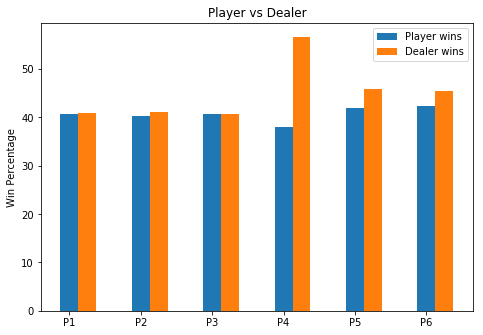

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import pandas as pd

p1 = get_stats(policy_1, 1000000)
p2 = get_stats(policy_2, 1000000)
p3 = get_stats(policy_3, 1000000)
p4 = get_stats(policy_4, 1000000)
p5 = get_stats(policy_5, 1000000)
p6 = get_stats(policy_6, 1000000)

p1_wins = p1['P_Wins']/p1['num_of_tests']*100
p2_wins = p2['P_Wins']/p2['num_of_tests']*100
p3_wins = p3['P_Wins']/p3['num_of_tests']*100
p4_wins = p4['P_Wins']/p4['num_of_tests']*100
p5_wins = p5['P_Wins']/p5['num_of_tests']*100
p6_wins = p6['P_Wins']/p6['num_of_tests']*100
player_wins = [p1_wins, p2_wins, p3_wins, p4_wins, p5_wins, p6_wins]

p1_wins = p1['D_Wins']/p1['num_of_tests']*100
p2_wins = p2['D_Wins']/p2['num_of_tests']*100
p3_wins = p3['D_Wins']/p3['num_of_tests']*100
p4_wins = p4['D_Wins']/p4['num_of_tests']*100
p5_wins = p5['D_Wins']/p5['num_of_tests']*100
p6_wins = p6['D_Wins']/p6['num_of_tests']*100
dealer_wins = [p1_wins, p2_wins, p3_wins, p4_wins, p5_wins, p6_wins]

labels = ('P1', 'P2', 'P3', 'P4', 'P5', 'P6')

x = np.arange(len(labels))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(x, player_wins, width = 0.25, label = 'Player wins') 
ax.bar(x + 0.25, dealer_wins, width = 0.25, label = 'Dealer wins')

plt.xticks(x, labels)
plt.ylabel('Win Percentage')
plt.title('Player vs Dealer')
plt.legend(loc='best')

plt.show()

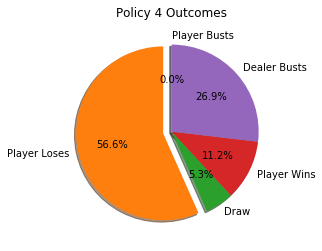

In [94]:
#Policy 4 Stats
p4 = get_stats_mod(policy_4, 1000000)

labels = ('Player Busts', 'Player Loses', 'Draw', 'Player Wins', 'Dealer Busts')

performance = p4_array
 
explode = (0, 0.1, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Player Loses')

plt.pie(performance, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Policy 4 Outcomes')
 
plt.show()

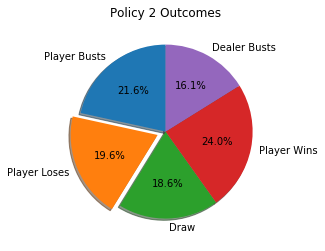

In [95]:
#Policy 2 Stats
p2 = get_stats_mod(policy_2, 1000000)

labels = ('Player Busts', 'Player Loses', 'Draw', 'Player Wins', 'Dealer Busts')

performance = p2_array

explode = (0, 0.1, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Player Loses')
 
plt.pie(performance, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Policy 2 Outcomes')
 
plt.show()

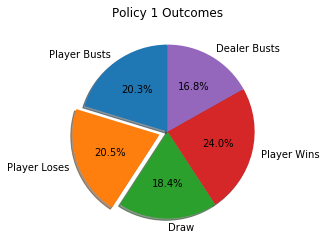

In [99]:
p1 = get_stats_mod(policy_1, 1000000)

labels = ('Player Busts', 'Player Loses', 'Draw', 'Player Wins', 'Dealer Busts')

performance = p1_array
 
explode = (0, 0.1, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Player Loses')

plt.pie(performance, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Policy 1 Outcomes')
 
plt.show()